<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [303]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.utils import resample
%matplotlib inline


This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-11-14 13:50:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-11-14 13:50:43 (10.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [306]:
df = pd.read_csv('loan_train.csv')
df.head()
print(df.head)

<bound method NDFrame.head of      Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0             0             0     PAIDOFF       1000     30       9/8/2016   
1             2             2     PAIDOFF       1000     30       9/8/2016   
2             3             3     PAIDOFF       1000     15       9/8/2016   
3             4             4     PAIDOFF       1000     30       9/9/2016   
4             6             6     PAIDOFF       1000     30       9/9/2016   
5             7             7     PAIDOFF       1000     30       9/9/2016   
6             8             8     PAIDOFF       1000     30       9/9/2016   
7             9             9     PAIDOFF        800     15      9/10/2016   
8            10            10     PAIDOFF        300      7      9/10/2016   
9            11            11     PAIDOFF       1000     15      9/10/2016   
10           12            12     PAIDOFF       1000     30      9/10/2016   
11           13            13     

### About dataset

In [307]:
df.shape

(346, 10)

In [308]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()




,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Convert to date time object 

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [309]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [6]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



[ 300.    377.78  455.56  533.33  611.11  688.89  766.67  844.44  922.22
 1000.  ]


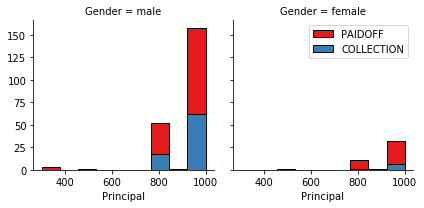

In [310]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
print(bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

[18.   21.67 25.33 29.   32.67 36.33 40.   43.67 47.33 51.  ]


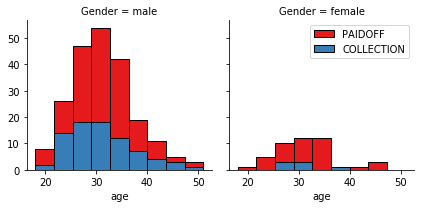

In [311]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
print(bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

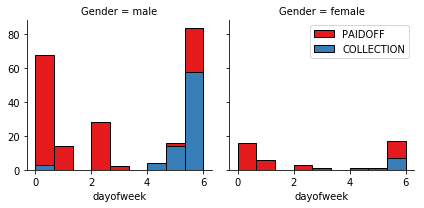

In [312]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [313]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [314]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [315]:
df['Gender'].replace(['male','female'], [0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [316]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [317]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [318]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [319]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [320]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [321]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Data Preparation

Unbalanced data set. There are too many 'PAIDOFF' values compared to the 'COLLECTION' data

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(242, 8) (242,)
(104, 8) (104,)


In [360]:
##X_train = pd.DataFrame(data=X_train[1:,1:], index=X_train[1:,0],columns=X_train[0,1:])  
X_trainnorm = pd.DataFrame(X_train)  
y_trainnorm = pd.DataFrame(y_train)
y_trainnorm.columns = (['loan_status'])

#concatenate our training data together
X_norm = pd.concat([X_trainnorm, y_trainnorm], axis = 1)
X_norm.head()



,0,1,2,3,4,5,6,7,loan_status
0,0.515785,-0.959111,-0.487392,-0.420560,0.829340,-0.381701,1.136394,-0.869681,PAIDOFF
1,0.515785,-1.961686,0.010064,-0.420560,0.829340,2.619854,-0.879977,-0.869681,PAIDOFF
2,0.515785,0.920718,0.175883,-0.420560,-1.205778,-0.381701,-0.879977,1.149847,PAIDOFF
3,0.515785,0.920718,1.170795,2.377782,0.829340,-0.381701,-0.879977,1.149847,COLLECTION
4,0.515785,0.920718,-0.984848,-0.420560,0.829340,-0.381701,1.136394,-0.869681,PAIDOFF


In [361]:
#separate minority and majority classes
PAIDOFF = X_norm[X_norm.loan_status == 'PAIDOFF']
COLLECTION = X_norm[X_norm.loan_status == 'COLLECTION']
print(PAIDOFF.shape)
print(COLLECTION.shape)

(178, 9)
(64, 9)


In [362]:
Collection_upsampled = resample(COLLECTION, replace = True, n_samples = len(PAIDOFF), random_state = 10)
print(Collection_upsampled.shape)

(178, 9)


In [363]:
#combine majority and upsamples minority
upsample = pd.concat([PAIDOFF,Collection_upsampled])
upsample.loan_status.value_counts()

PAIDOFF       178
COLLECTION    178
Name: loan_status, dtype: int64

In [364]:
y_trainbalanced = upsample.loan_status.values
X_trainbalanced = upsample.drop('loan_status', axis = 1)
print(y_trainbalanced.shape)
print(X_trainbalanced.shape)
print(y_train.shape)
print(X_train.shape)




(356,)
(356, 8)
(242,)
(242, 8)


# Definition of the Confusion Matrix

In [365]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [366]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range (1,Ks):
    KNNClassifier = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    y_pred = KNNClassifier.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    std_acc[n-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

np.column_stack((mean_acc,std_acc))

print("The best accuracy was :", mean_acc.max(), "with k = ", mean_acc.argmax()+1)
k = mean_acc.argmax()+1






The best accuracy was : 0.8173076923076923 with k =  3


In [367]:
KNNClassifier = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_predKNN = KNNClassifier.predict(X_test)

In [368]:
ResultAccuracyKNN = pd.DataFrame({'Metrics' : ['Train set Accuracy', 'Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_KNN': [metrics.accuracy_score(y_train, KNNClassifier.predict(X_train)),
                                            metrics.accuracy_score(y_test, y_predKNN),
                                            f1_score(y_test, y_predKNN, pos_label = 'COLLECTION'),
                                            f1_score(y_test, y_predKNN, pos_label = 'PAIDOFF'),
                                            jaccard_similarity_score(y_test, y_predKNN)
                                           ]})
ResultAccuracyKNN

,Metrics,Value_KNN
0,Train set Accuracy,0.814050
1,Test set Accuracy,0.817308
2,F1 Score Collection,0.595745
3,F1 Score Paidoff,0.881988
4,Jaccard Index,0.817308


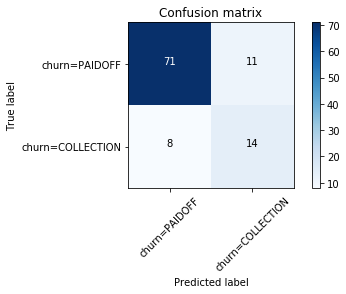

In [369]:
# Compute confusion matrix
cnf_matrix_KNN = confusion_matrix(y_test, y_predKNN, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_KNN, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix')

# Decision Tree

In [370]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range (3,Ks):
    DecisionTree = DecisionTreeClassifier(criterion = "entropy", max_depth = n ).fit(X_train, y_train)
    y_pred_Tree = DecisionTree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred_Tree)
    std_acc[n-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
    #print("DecisionTree accuracy: ", metrics.accuracy_score(y_test,y_pred_Tree))

np.column_stack((mean_acc,std_acc))

print("The best accuracy was :", mean_acc.max(), "with max_depth = ", mean_acc.argmax()+1)

The best accuracy was : 0.7884615384615384 with max_depth =  3


In [371]:
    DecisionTree = DecisionTreeClassifier(criterion = "entropy", max_depth = mean_acc.argmax()+1 ).fit(X_train, y_train)
    y_pred_Tree = DecisionTree.predict(X_test)
    print("DecisionTree accuracy: ", metrics.accuracy_score(y_test,y_pred_Tree))

DecisionTree accuracy:  0.7884615384615384


In [372]:
ResultAccuracyTree = pd.DataFrame({'Metrics' : ['Train set Accuracy', 'Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_Tree': [metrics.accuracy_score(y_train, DecisionTree.predict(X_train)),
                                            metrics.accuracy_score(y_test, y_pred_Tree),
                                            f1_score(y_test, y_pred_Tree, pos_label = 'COLLECTION'),
                                            f1_score(y_test, y_pred_Tree, pos_label = 'PAIDOFF'),
                                            jaccard_similarity_score(y_test, y_pred_Tree)
                                           ]})
ResultAccuracyTree

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Metrics,Value_Tree
0,Train set Accuracy,0.735537
1,Test set Accuracy,0.788462
2,F1 Score Collection,0.000000
3,F1 Score Paidoff,0.881720
4,Jaccard Index,0.788462


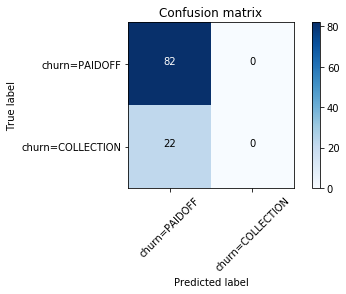

In [373]:
# Compute confusion matrix
cnf_matrix_Tree = confusion_matrix(y_test, y_pred_Tree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_Tree, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [374]:
# replace Paidoff value with 1 and Collection values with 0 in y_test creating new array y_test_int
y_test_int = y_test
y_test_int[y_test_int == 'PAIDOFF'] = 1
y_test_int[y_test_int == 'COLLECTION'] = 0
y_test_int=y_test_int.astype('int')


# replace Paidoff value with 1 and Collection values with 0 in y_train creating new array y_train_int
y_train_int = y_train
y_train_int[y_train_int == 'PAIDOFF'] = 1
y_train_int[y_train_int == 'COLLECTION'] = 0
y_train_int=y_train_int.astype('int')

In [375]:
LR = LogisticRegression(C=0.01, solver = 'liblinear').fit(X_train, y_train_int)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [376]:
ypredLR = LR.predict(X_test)
yproba = LR.predict_proba(X_test)
metrics.accuracy_score(y_train_int, LR.predict(X_train))

0.7355371900826446

In [377]:
ResultAccuracyLR = pd.DataFrame({'Metrics' : ['Train set Accuracy', 'Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_LR': [metrics.accuracy_score(y_train_int, LR.predict(X_train)),
                                            metrics.accuracy_score(y_test_int, ypredLR),
                                            f1_score(y_test_int, ypredLR, pos_label = 0),
                                            f1_score(y_test_int, ypredLR, pos_label = 1),
                                            jaccard_similarity_score(y_test_int, ypredLR)
                                           ]})
ResultAccuracyLR

,Metrics,Value_LR
0,Train set Accuracy,0.735537
1,Test set Accuracy,0.798077
2,F1 Score Collection,0.222222
3,F1 Score Paidoff,0.883978
4,Jaccard Index,0.798077


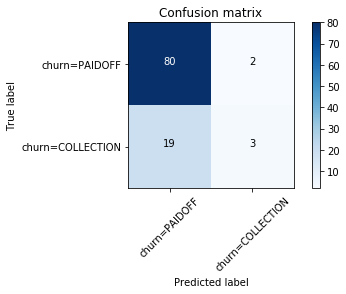

In [378]:
# Compute confusion matrix
cnf_matrix_LR = confusion_matrix(y_test_int, ypredLR, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix')

# Support Vector Machine

In [379]:
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train_int)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [380]:
ypredSVM = clf.predict(X_test)
ypredSVM[0:5]

array([1, 1, 1, 1, 1])

In [165]:
ResultAccuracySVM = pd.DataFrame({'Metrics' : ['Train set Accuracy', 'Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_SVM': [metrics.accuracy_score(y_train_int, clf.predict(X_train)),
                                            metrics.accuracy_score(y_test_int, ypredSVM),
                                            f1_score(y_test_int, ypredSVM, pos_label = 0),
                                            f1_score(y_test_int, ypredSVM, pos_label = 1),
                                            jaccard_similarity_score(y_test_int, ypredSVM)
                                           ]})
ResultAccuracySVM

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Metrics,Value_SVM
0,Train set Accuracy,0.756198
1,Test set Accuracy,0.788462
2,F1 Score Collection,0.000000
3,F1 Score Paidoff,0.881720
4,Jaccard Index,0.788462


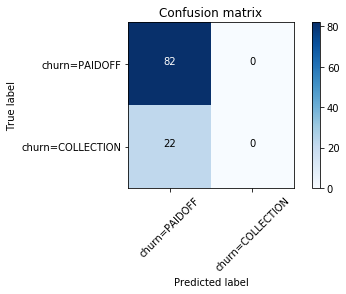

In [381]:
# Compute confusion matrix
cnf_matrix_SVM = confusion_matrix(y_test_int, ypredSVM, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SVM, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix')

# Model Evaluation using Test set

First, download and load the test set:

In [385]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-11-14 17:25:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-11-14 17:25:59 (287 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [386]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(['male','female'], [0,1],inplace=True)
Feature_Test_Set = test_df[['Principal','terms','age','Gender','weekend']]
Feature_Test_Set = pd.concat([Feature_Test_Set,pd.get_dummies(test_df['education'])], axis=1)
Feature_Test_Set.drop(['Master or Above'], axis = 1,inplace=True)
X_Test_Set = Feature_Test_Set
y_Test_Set = test_df['loan_status'].values
X_Test_Set= preprocessing.StandardScaler().fit(X_Test_Set).transform(X_Test_Set)


# replace Paidoff value with 1 and Collection values with 0 in y_Test_Set creating new array y_Test_Set_int
y_Test_Set_int[y_Test_Set == 'PAIDOFF'] = 1
y_Test_Set_int[y_Test_Set == 'COLLECTION'] = 0
y_Test_Set_int=y_Test_Set_int.astype('int')




/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [387]:
ypred_KNN_Test = KNNClassifier.predict(X_Test_Set)
ResultAccuracyKNN_Test_Set = pd.DataFrame({'Metrics' : [ 'Test Set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index','Logloss'],
                                  'Value_KNN': [metrics.accuracy_score(y_Test_Set, ypred_KNN_Test),
                                            f1_score(y_Test_Set, ypred_KNN_Test, pos_label = 'COLLECTION'),
                                            f1_score(y_Test_Set, ypred_KNN_Test, pos_label = 'PAIDOFF'),
                                            jaccard_similarity_score(y_Test_Set, ypred_KNN_Test),
                                                'NaN'
                                           ]})


In [388]:
ypred_Tree_Test = DecisionTree.predict(X_Test_Set)
ResultAccuracyTree_Test_Set = pd.DataFrame({'Metrics' : ['Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_Tree': [metrics.accuracy_score(y_Test_Set, ypred_Tree_Test),
                                            f1_score(y_Test_Set, ypred_Tree_Test, pos_label = 'COLLECTION'),
                                            f1_score(y_Test_Set, ypred_Tree_Test, pos_label = 'PAIDOFF'),
                                            jaccard_similarity_score(y_Test_Set, ypred_Tree_Test)
                                           ]})


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [389]:
ypred_LR_Test = LR.predict(X_Test_Set)
ResultAccuracyLR_Test_Set = pd.DataFrame({'Metrics' : ['Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index'],
                                  'Value_LR': [metrics.accuracy_score(y_Test_Set_int, ypred_LR_Test),
                                            f1_score(y_Test_Set_int, ypred_LR_Test, pos_label = 0),
                                            f1_score(y_Test_Set_int, ypred_LR_Test, pos_label = 1),
                                            jaccard_similarity_score(y_Test_Set_int, ypred_LR_Test)
                                           ]})


In [390]:
ypredSVM_Test = clf.predict(X_Test_Set)
ResultAccuracySVM_Test_Set = pd.DataFrame({'Metrics' : [ 'Test set Accuracy','F1 Score Collection','F1 Score Paidoff','Jaccard Index','LogLoss'],
                                  'Value_SVM': [metrics.accuracy_score(y_Test_Set_int, ypredSVM_Test),
                                            f1_score(y_Test_Set_int, ypredSVM_Test, pos_label = 0),
                                            f1_score(y_Test_Set_int, ypredSVM_Test, pos_label = 1),
                                            jaccard_similarity_score(y_Test_Set_int, ypredSVM_Test),
                                            log_loss(y_Test_Set_int, ypredSVM_Test)
                                           ]})
ResultAccuracySVM_Test_Set

,Metrics,Value_SVM
0,Test set Accuracy,0.703704
1,F1 Score Collection,0.000000
2,F1 Score Paidoff,0.826087
3,Jaccard Index,0.703704
4,LogLoss,10.233919


In [391]:
Confusion_Matrix_Comparison_Test = pd.concat([ResultAccuracyKNN_Test_Set,ResultAccuracyTree_Test_Set['Value_Tree'],ResultAccuracyLR_Test_Set['Value_LR'],ResultAccuracySVM_Test_Set['Value_SVM']], axis=1)

Confusion_Matrix_Comparison_Test
#Confusion_Matrix_Comparison_Test.style.apply(lambda x: ['background: lightblue'] if x.name == 'Value_SVM' else '' for i in x)

,Metrics,Value_KNN,Value_Tree,Value_LR,Value_SVM
0,Test Set Accuracy,0.648148,0.740741,0.759259,0.703704
1,F1 Score Collection,0.296296,0.000000,0.133333,0.000000
2,F1 Score Paidoff,0.765432,0.851064,0.860215,0.826087
3,Jaccard Index,0.648148,0.740741,0.759259,0.703704
4,Logloss,NaN,NaN,NaN,10.233919


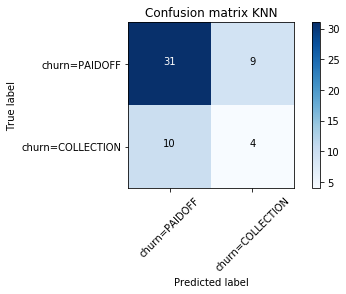

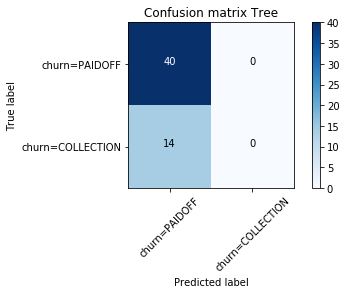

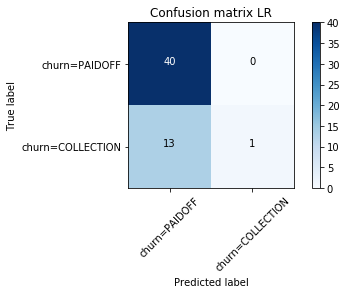

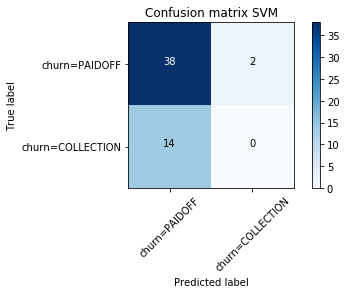

In [392]:
# Compute confusion matrix KNN
cnf_matrix_KNN_Test = confusion_matrix(y_Test_Set, ypred_KNN_Test, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix 
plt.figure()
plot_confusion_matrix(cnf_matrix_KNN_Test, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix KNN')

# Compute confusion matrix Tree
cnf_matrix_Tree_Test = confusion_matrix(y_Test_Set, ypred_Tree_Test, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix 
plt.figure()
plot_confusion_matrix(cnf_matrix_Tree_Test, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix Tree')

# Compute confusion matrix LR
cnf_matrix_LR_Test = confusion_matrix(y_Test_Set_int, ypred_LR_Test, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LR_Test, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix LR')


# Compute confusion matrix SVM
cnf_matrix_SVM_Test = confusion_matrix(y_Test_Set_int, ypredSVM_Test, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SVM_Test, classes=['churn=PAIDOFF','churn=COLLECTION'],normalize= False,  title='Confusion matrix SVM')

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [284]:
Confusion_Matrix_Comparison_Test
def highlight_col(x):
    r = 'background-color: yellow'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 3] = r
    return df1    
Confusion_Matrix_Comparison_Test.style.apply(highlight_col, axis=None)


,Metrics,Value_KNN,Value_Tree,Value_LR,Value_SVM
0,Test Set Accuracy,0.648148,0.740741,0.759259,0.703704
1,F1 Score Collection,0.296296,0,0.133333,0
2,F1 Score Paidoff,0.765432,0.851064,0.860215,0.826087
3,Jaccard Index,0.648148,0.740741,0.759259,0.703704
4,Logloss,NaN,nan,nan,10.2339


The logistic regression corretly predicted 41 values out of 54 with an accuray of 76% 

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>